In [1]:
r"""
This tutorial shows how to use the toy models - the minimal models of the which allow to tackle different types of relaxation
in materials of different dimensionality

We also consider automatic addition of the dipole-dipole interaction and its impact on the magnon spectrum
"""

import numpy as np
import matplotlib.pyplot as plt

import os
import sys
script_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.abspath(os.path.join(script_dir, '..','Src'))  # adjust '..' depending where you are
sys.path.insert(0, project_root)

import MagnoFallas as mfal


In [2]:
#####   First we define the parameters of the toy models
J = 3.0     ## Heisenberg exhange, meV
kappa = 0.01    ## leads to kappa*J = 0.03 meV
a = 3.0    ### Lattice constant, angstr
c = 15   ### sound velocity
S = 3/2  ## spin of the magnetic atoms (integer of half-integer)

In [3]:
### Here we initialize the Ferromagnetic 2D and 3D toy models
tmF2D = mfal.ToyModelFM(J, kappa, a, c=c, S=S, dim=2)
tmF3D = mfal.ToyModelFM(J, kappa, a, c=c, S=S, dim=3)

### Here we initialize the Antiferromagnetic 2D and 3D toy models
tmAF2D = mfal.ToyModelAFM(J, kappa, a, c=c, S=S, dim=2)
tmAF3D = mfal.ToyModelAFM(J, kappa, a, c=c, S=S, dim=3)

In [4]:
### For the sake of comparison, we calculate the magnon dispersions of both the FM and AFM models with the same K-path
### The k-path is provided by the model
kpoi2F, xx2F, Xmarks2F, Labels2F = tmF2D.Kpath()
kpoi3F, xx3F, Xmarks3F, Labels3F = tmF3D.Kpath()

om2F = np.array([tmF2D.Magn.omega(k) for k in kpoi2F])
om2AF = np.array([tmAF2D.Magn.omega(k) for k in kpoi2F])

om3F = np.array([tmF3D.Magn.omega(k) for k in kpoi3F])
om3AF = np.array([tmAF3D.Magn.omega(k) for k in kpoi3F])

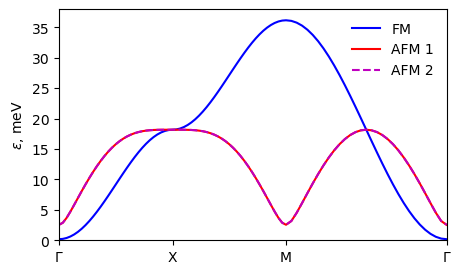

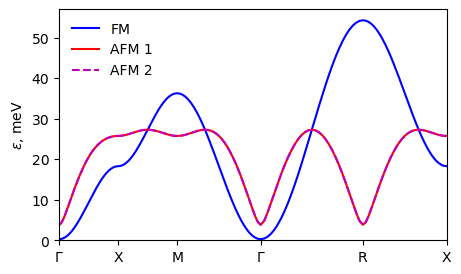

In [5]:
### Here we plot the calculated magnon dispersions
plt.figure(figsize=(5,3))
plt.plot(xx2F, om2F, 'b-', label='FM')
plt.plot(xx2F, om2AF[...,0], 'r-', label='AFM 1')
plt.plot(xx2F, om2AF[...,1], 'm--', label='AFM 2')
plt.xlim(0,np.max(xx2F))
plt.ylim(0,1.05*np.max(om2F))
plt.xticks(Xmarks2F, Labels2F)
plt.ylabel(r'$\varepsilon$, meV')
plt.legend(frameon=False)
plt.savefig('ModelDispersion2D.png', bbox_inches='tight')
plt.show()


plt.figure(figsize=(5,3))
plt.plot(xx3F, om3F, 'b-', label='FM')
plt.plot(xx3F, om3AF[...,0], 'r-', label='AFM 1')
plt.plot(xx3F, om3AF[...,1], 'm--', label='AFM 2')
plt.xlim(0,np.max(xx3F))
plt.ylim(0,1.05*np.max(om3F))
plt.xticks(Xmarks3F, Labels3F)
plt.ylabel(r'$\varepsilon$, meV')
plt.legend(frameon=False)
plt.savefig('ModelDispersion3D.png', bbox_inches='tight')
plt.show()

### in the AFM model the magnon bands are double-degenrate, the magnon gap is significanly larger, and M-point in 2D (R-point in 3D) 
### become equivalent to the Gamma-point
### With decreasing Kappa, the AFM magnon dispersion will tend to become linear in small k

In [6]:
### Now we automatically add dipole-dipole interaction to the Hamiltonian of 2D and 3D FM model
### in different approximations

In [7]:
H0 = tmF2D.SH

### we consider three cutoff distances, 6, 12 and 24 angstr
## first step is always to add short-range dipole-dipole interaction (SRDD)
## to the spin Hamiltonian
H6 = mfal.AddSRDD(H0, 6, dim=2)
H12 = mfal.AddSRDD(H0, 12, dim=2)
H24 = mfal.AddSRDD(H0, 24, dim=2)

In [8]:
### we create the numba-compatible Hamiltonians for the two reasons:
### - to facilitate the calculations
### - because long-range dipole-dipole interaction (LRDD) can be added only to numba-compatible methods

B0 = 1.0
## magnetic field of 1.0 T
## the studied spin-Hamiltonians correspond to a thin film with magnetization perpendicular to the field
## at zero magnetic field magnetization in such a fim form domains, as the uniformly magnetized ground state
## is unstable due to the long-range dipole-dipole interaction
## accordingly, especially with LRDD, it is important to include external field to calculate the magnon spectrum

nbH0 = mfal.NBhamiltonian(H0, B=B0, LR=False)

## this versions of the Hamiltonians include only SRDD (LR=False)
nbH6s = mfal.NBhamiltonian(H6, B=B0, LR=False)
nbH12s = mfal.NBhamiltonian(H12, B=B0, LR=False)
nbH24s = mfal.NBhamiltonian(H24, B=B0, LR=False)

## when adding LRDD it is important to:
## - correctly set the dimensionality of the system: analitical expresions used for LRDD are different in 2D and 3D
## - the parameter R0 should match the SRDD added to the Hamiltonian on the previous step
nbH6l = mfal.NBhamiltonian(H6, B=B0, LR=True, dim=2, R0=6)
nbH12l = mfal.NBhamiltonian(H12, B=B0, LR=True, dim=2, R0=12)
nbH24l = mfal.NBhamiltonian(H24, B=B0, LR=True, dim=2, R0=24)

In [9]:
### Because the effect of the dipole-dipole interaciton is expected to be strong for small wavevectors,
### we construct a special k-pathe near the Gamma-point to study it
PG =  np.zeros(3)
Px1 = np.array([0.05, 0, 0])
Py1 = np.array([0, 0.05, 0])
Pz1 = np.array([0, 0, 0.05])

Points2D = [Px1, PG, Py1]
Labels2D = [r'$k_x = 0.05\,A^{-1}$', r'$\Gamma$', r'$k_y = 0.05\,A^{-1}$']
kpoi2D, xx2D, Xmarks2D = mfal.Kpath(Points2D)

In [10]:
### Here we caclulate the magnon dispersion with thr 
## numba-compatible method

om0 = np.array([mfal.NBomega(nbH0, k) for k in kpoi2D])

om6s = np.array([mfal.NBomega(nbH6s, k) for k in kpoi2D])
om12s = np.array([mfal.NBomega(nbH12s, k) for k in kpoi2D])
om24s = np.array([mfal.NBomega(nbH24s, k) for k in kpoi2D])

om6l = np.array([mfal.NBomega(nbH6l, k) for k in kpoi2D])
om12l = np.array([mfal.NBomega(nbH12l, k) for k in kpoi2D])
om24l = np.array([mfal.NBomega(nbH24l, k) for k in kpoi2D])

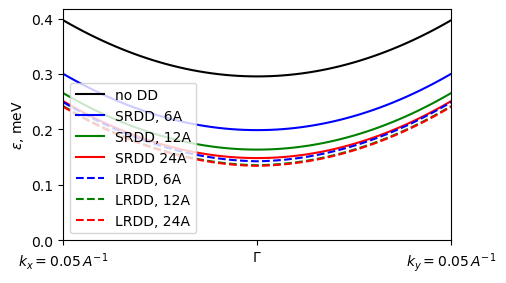

In [11]:
plt.figure(figsize=(5,3))
plt.plot(xx2D, om0, 'k-', label='no DD')
plt.plot(xx2D, om6s, 'b-', label='SRDD, 6A')
plt.plot(xx2D, om12s, 'g-', label='SRDD, 12A')
plt.plot(xx2D, om24s, 'r-', label='SRDD 24A')

plt.plot(xx2D, om6l, 'b--', label='LRDD, 6A')
plt.plot(xx2D, om12l, 'g--', label='LRDD, 12A')
plt.plot(xx2D, om24l, 'r--', label='LRDD, 24A')
plt.xlim(0,np.max(xx2D))
plt.ylim(0,1.05*np.max(om0))
plt.xticks(Xmarks2D, Labels2D)
plt.ylabel(r'$\varepsilon$, meV')
plt.legend(frameon=True)
plt.savefig('Dipole-Dipole2D.png', bbox_inches='tight')
plt.show()

##
##  In 2D the dispersion calculated with only SRDD, but with large R0
##  converges to the one with LRDD included
##  however, LRDD allows to get the correct result with significanly smaller R0 parameter

In [12]:
#
#  Now we repeat the same calculations for the 3D model
#

In [13]:
H0_3d = tmF3D.SH

H25_3d = mfal.AddSRDD(H0_3d, 25, dim=3)
H50_3d = mfal.AddSRDD(H0_3d, 50, dim=3)
H75_3d = mfal.AddSRDD(H0_3d, 75, dim=3)

In [14]:
#
# Effect of the long-range dipole-dipole interaction is significantly more pronounced in 3D
# to have a representative comparison with SRDD we need much larger cut-offs R0
# we select 25, 50 and 75 angstr for the demonstration
#

# in 3D the anisotropy included into the model is sufficient to make the macroscopic FM
# stable without external magnetic field, therefore we switch it off
B0 = 0.0

nbH0_3d = mfal.NBhamiltonian(H0_3d, B=B0, LR=False)


nbH25s_3d = mfal.NBhamiltonian(H25_3d, B=B0, LR=False)
nbH50s_3d = mfal.NBhamiltonian(H50_3d, B=B0, LR=False)
nbH75s_3d = mfal.NBhamiltonian(H75_3d, B=B0, LR=False)

nbH25l_3d = mfal.NBhamiltonian(H25_3d, B=B0, LR=True, dim=3, R0=25)
nbH50l_3d = mfal.NBhamiltonian(H50_3d, B=B0, LR=True, dim=3, R0=50)
nbH75l_3d = mfal.NBhamiltonian(H75_3d, B=B0, LR=True, dim=3, R0=75)

In [15]:
#
# In both the models the magnetization is along z-axis
# Therefore in 3D it is reasonable to compare x- and z-direction
# for magnons
#

PG =  np.zeros(3)
Px1 = np.array([0.07, 0, 0])
Py1 = np.array([0, 0.07, 0])
Pz1 = np.array([0, 0, 0.07])

Points3D = [Px1, PG, Pz1]
Labels3D = [r'$k_x = 0.07\,A^{-1}$', r'$\Gamma$', r'$k_z = 0.07\,A^{-1}$']
kpoi3D, xx3D, Xmarks3D = mfal.Kpath(Points3D)

In [16]:
om0_3d = np.array([mfal.NBomega(nbH0_3d, k) for k in kpoi3D])

om6s_3d = np.array([mfal.NBomega(nbH25s_3d, k) for k in kpoi3D])
om12s_3d = np.array([mfal.NBomega(nbH50s_3d, k) for k in kpoi3D])
om24s_3d = np.array([mfal.NBomega(nbH75s_3d, k) for k in kpoi3D])

om6l_3d = np.array([mfal.NBomega(nbH25l_3d, k) for k in kpoi3D])
om12l_3d = np.array([mfal.NBomega(nbH50l_3d, k) for k in kpoi3D])
om24l_3d = np.array([mfal.NBomega(nbH75l_3d, k) for k in kpoi3D])

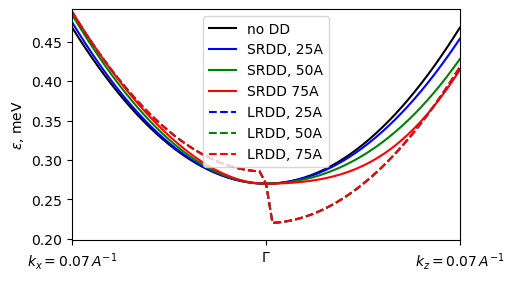

In [17]:
plt.figure(figsize=(5,3))
plt.plot(xx3D, om0_3d, 'k-', label='no DD')
plt.plot(xx3D, om6s_3d, 'b-', label='SRDD, 25A')
plt.plot(xx3D, om12s_3d, 'g-', label='SRDD, 50A')
plt.plot(xx3D, om24s_3d, 'r-', label='SRDD 75A')

plt.plot(xx3D, om6l_3d, 'b--', label='LRDD, 25A')
plt.plot(xx3D, om12l_3d, 'g--', label='LRDD, 50A')
plt.plot(xx3D, om24l_3d, 'r--', label='LRDD, 75A')
plt.xlim(0,np.max(xx3D))
plt.ylim(0.9*np.min(om24l_3d),1.05*np.max(om0_3d))
plt.xticks(Xmarks3D, Labels3D)
plt.ylabel(r'$\varepsilon$, meV')
plt.legend(frameon=True)
plt.savefig('Dipole-Dipole3D.png', bbox_inches='tight')
plt.show()

#
# The effect of dipole-dipole interaction (and especially LRDD) is different compared to 3D
# Because of the very weak convergence of dipole-dipole interaction, SRDD even with a very
# large cut-off distance can describe magnon correctly onlr startibg from some finite wavevector
# also, there is a singularity on magnon dispersion at Gamma-point leading to the magnon energy
# dependence on magnon propagation direction even for very small absolute values of the wavevector